In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

from sklearn.linear_model import LogisticRegression
import joblib

In [3]:
# Load featured data
DATA_PATH = "../../data/cleaned-data.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,1
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,1
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,1


In [4]:
# Dataset Info
print("Shape:", df.shape)
df.info()

Shape: (3630, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3630 entries, 0 to 3629
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  3630 non-null   int64  
 1   Application mode                                3630 non-null   int64  
 2   Application order                               3630 non-null   int64  
 3   Course                                          3630 non-null   int64  
 4   Daytime/evening attendance	                     3630 non-null   int64  
 5   Previous qualification                          3630 non-null   int64  
 6   Previous qualification (grade)                  3630 non-null   float64
 7   Nacionality                                     3630 non-null   int64  
 8   Mother's qualification                          3630 non-null   int64  
 9   Father's qualification 

In [5]:
# Prepare Features and Target
target_col = "Target"

X = df.drop(columns=[target_col])
y = df[target_col]

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y   # important for class balance
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (2722, 36)
Test size: (908, 36)


In [7]:
# Pipeline (Scaler + Logistic Regression)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(random_state=42, max_iter=1000))
])

In [8]:
# Hyperparameter Grid for Logistic Regression
param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs", "liblinear"]
}

In [9]:
# Grid Search CV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

In [10]:
# Train model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__penalty': ['l2'],
                         'model__solver': ['lbfgs', 'liblinear']},
             scoring='accuracy', verbose=1)

In [11]:
# Best Model & Best Parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:\n", best_params)

Best Parameters:
 {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [12]:
# Predictions
y_pred = best_model.predict(X_test)

In [13]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9151982378854625

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.88       355
           1       0.90      0.97      0.93       553

    accuracy                           0.92       908
   macro avg       0.92      0.90      0.91       908
weighted avg       0.92      0.92      0.91       908



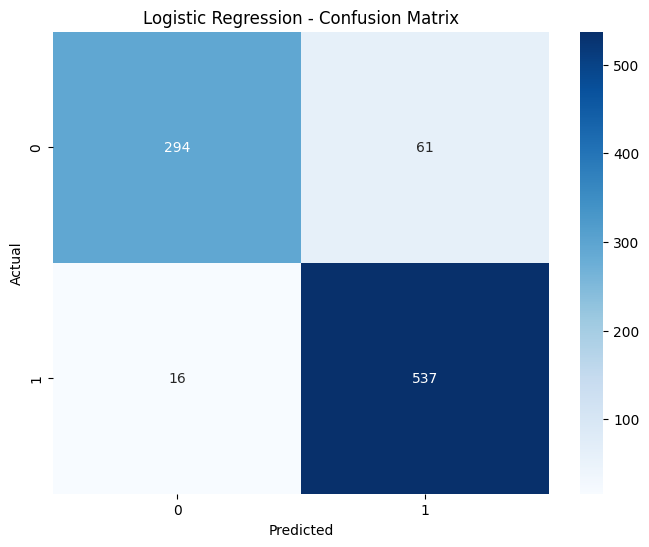

In [14]:
# Confusion Matrix Graph
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

In [15]:
# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[['param_model__C', 'param_model__solver', 'mean_test_score', 'std_test_score']]
results_df.columns = ['C', 'Solver', 'Mean Accuracy', 'Std Deviation']

results_df.head()

,C,Solver,Mean Accuracy,Std Deviation
0,0.01,lbfgs,0.901548,0.012615
1,0.01,liblinear,0.908894,0.008223
2,0.10,lbfgs,0.909997,0.008246
3,0.10,liblinear,0.909629,0.008117
4,1.00,lbfgs,0.909261,0.005835


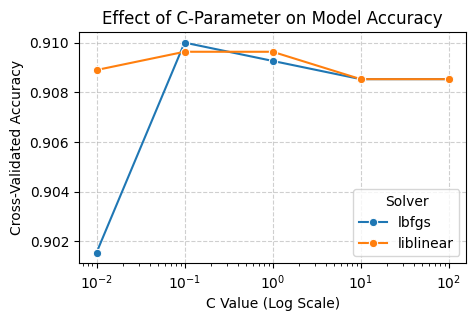

In [17]:
# Plotting C-Parameter vs Mean Test Score
plt.figure(figsize=(5, 3))
sns.lineplot(data=results_df, x='C', y='Mean Accuracy', hue='Solver', marker='o')

plt.xscale('log')
plt.title("Effect of C-Parameter on Model Accuracy")
plt.xlabel("C Value (Log Scale)")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

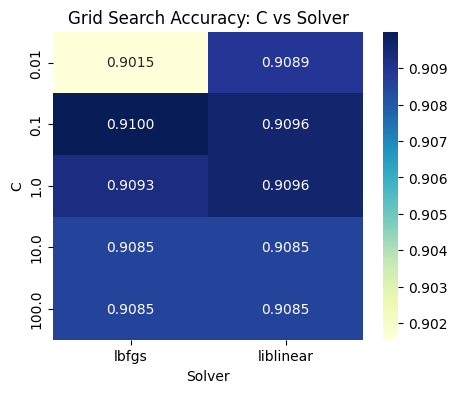

In [21]:
# Pivot the data for Heatmap
pivot_table = results_df.pivot(index='C', columns='Solver', values='Mean Accuracy')

plt.figure(figsize=(5, 4))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".4f")

plt.title("Grid Search Accuracy: C vs Solver")
plt.show()

In [ ]:
# result dataframe for all combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_5_results = results_df.nlargest(5, 'mean_test_score')

# Convert params to string for better visualization
top_5_results['params_str'] = top_5_results['params'].apply(lambda x: str(x))

plt.figure(figsize=(12, 7))
sns.barplot(data=top_5_results, x='mean_test_score', y='params_str', palette='magma')
plt.xlim(top_5_results['mean_test_score'].min() - 0.005, top_5_results['mean_test_score'].max() + 0.005)
plt.title('XGBoost: Top 5 Hyperparameter Combinations vs Accuracy')
plt.xlabel('Mean Test Accuracy')
plt.ylabel('Configuration')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [22]:
# Display top 5 parameter combinations
top_results = results_df.sort_values(by='Mean Accuracy', ascending=False).head(5)

print("Top 5 Hyperparameter Combinations:")
print(top_results)

Top 5 Hyperparameter Combinations:
      C     Solver  Mean Accuracy  Std Deviation
2  0.10      lbfgs       0.909997       0.008246
3  0.10  liblinear       0.909629       0.008117
5  1.00  liblinear       0.909628       0.005061
4  1.00      lbfgs       0.909261       0.005835
1  0.01  liblinear       0.908894       0.008223


C:\Users\Admin\AppData\Local\Temp\ipykernel_10204\1794451746.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Solver', y='Mean Accuracy', palette='viridis')


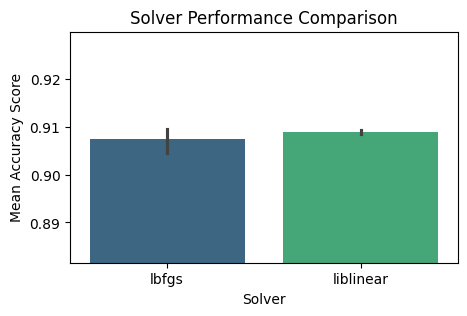

In [19]:
# Comparison of different Solvers
plt.figure(figsize=(5, 3))
sns.barplot(data=results_df, x='Solver', y='Mean Accuracy', palette='viridis')

plt.title("Solver Performance Comparison")
plt.ylim(results_df['Mean Accuracy'].min() - 0.02, results_df['Mean Accuracy'].max() + 0.02)
plt.ylabel("Mean Accuracy Score")
plt.show()

In [23]:
# Save the test data
joblib.dump(X_test, "../../models & test data/logistic-X_test.pkl")
joblib.dump(y_test, "../../models & test data/logistic-y_test.pkl")

['../../models & test data/logistic-y_test.pkl']

In [25]:
# Save the best model
joblib.dump(best_model, "../../models & test data/logistic-regression-model.pkl")

['../../models & test data/logistic-regression-model.pkl']